In [125]:
import os
import sys
import time
from enum import Enum

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from functional import seq
from math import sqrt
import multiprocessing as mp

# Load the "autoreload" extension
% reload_ext autoreload

# always reload modules marked with "%aimport"
% autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir, 'src')
sys.path.append(src_dir)

In [127]:
class PeriodColumns(Enum):
    ID = 'id'
    OPEN = 'open'
    CLOSE = 'close'
    HIGH = 'high'
    LOW = 'low'
    VOLUME = 'volume'
    WEIGHTED_AVERAGE = 'weightedAverage'
    BASE_PRICE = 'basePrice'
    BASE_PRICE_BIN = 'basePriceBin'

    def __init__(self, column_name):
        self.column_name = column_name


class BinColumns(Enum):
    BIN_ID = 'binId'
    AGG_VOLUME = 'aggVolume'
    LAST_PREVIOUS_BIN_ID = 'recentStrongestBinId'
    CONTAINS_BUY_ORDER = 'containsBuyOrder'

    OLD_LAST_AGG_VOLUME = 'oldLastAggVolume'
    OLD_LAST_MAX_VOLUME = 'oldLastMaxVolume'
    OLD_LAST_BASE_PRICE = 'oldLastBasePrice'
    OLD_ONE_BEFORE_LAST_AGG_VOLUME = 'oldOneBeforeLastAggVolume'
    OLD_ONE_BEFORE_LAST_MAX_VOLUME = 'oldOneBeforeLastMaxVolume'
    OLD_PERIOD_START = 'oldPeriodStart'
    OLD_PERIOD_END = 'oldPeriodEnd'
    OLD_BASE_SCORE = 'oldBaseScore'

    NEW_LAST_AGG_VOLUME = 'newLastAggVolume'
    NEW_LAST_MAX_VOLUME = 'newLastMaxVolume'
    NEW_LAST_BASE_PRICE = 'newLastBasePrice'
    NEW_ONE_BEFORE_LAST_AGG_VOLUME = 'newOneBeforeLastAggVolume'
    NEW_ONE_BEFORE_LAST_MAX_VOLUME = 'newOneBeforeLastMaxVolume'
    NEW_PERIOD_START = 'newPeriodStart'
    NEW_PERIOD_END = 'newPeriodEnd'
    NEW_BASE_SCORE = 'newBaseScore'

    def __init__(self, column_name):
        self.column_name = column_name


def calculate_profit_in_percents(sell_price_without_fee, buy_price_without_fee):
    sell_price_with_fee = sell_price_without_fee * (1 - trading_fee_decimal)
    buy_price_with_fee = buy_price_without_fee * (1 + trading_fee_decimal)
    return (sell_price_with_fee / buy_price_with_fee - 1) * 100


def add_trading_fee_to_volume(volume):
    return volume / (1 + trading_fee_decimal)


def subtract_trading_fee_from_volume(volume):
    return volume / (1 - trading_fee_decimal)


def calculate_trading_fee(price, volume):
    return price * volume * trading_fee_decimal


class CurrencyPair:
    def __init__(self, base_currency_symbol, target_currency_symbol, min_target_currency_investment):
        self.base_currency_symbol = base_currency_symbol
        self.target_currency_symbol = target_currency_symbol
        self.min_target_currency_investment = min_target_currency_investment

    def get_name(self):
        return '{}_{}'.format(self.base_currency_symbol, self.target_currency_symbol)


class Wallet:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
        self.base_currency_amount = 0
        self.base_currency_paid_on_fees = 0
        self.target_currency_amount = 0

    def buy(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        if self.base_currency_amount < price * volume_with_fee:
            bought_volume_without_fee = subtract_trading_fee_from_volume(self.base_currency_amount / price)
            self.target_currency_amount += bought_volume_without_fee
            self.base_currency_amount = 0
            self.base_currency_paid_on_fees += calculate_trading_fee(price, bought_volume_without_fee)
            return bought_volume_without_fee
        else:
            self.target_currency_amount += volume
            self.base_currency_amount -= price * volume_with_fee
            self.base_currency_paid_on_fees += calculate_trading_fee(price, volume)
            return volume

    def sell(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        sold_volume_with_fee = min(self.target_currency_amount, volume_with_fee)
        sold_volume_without_fee = subtract_trading_fee_from_volume(sold_volume_with_fee)
        self.target_currency_amount -= sold_volume_with_fee
        self.base_currency_amount += price * sold_volume_without_fee
        self.base_currency_paid_on_fees += calculate_trading_fee(price, sold_volume_without_fee)
        return sold_volume_without_fee

    def get_total_in_base_currency(self, current_price):
        return self.base_currency_amount + current_price * self.target_currency_amount

    def to_string(self, current_price):
        return 'WALLET: {} {:9.4f}, {} {:9.4f} => in total {} {:9.4f}, spent on fees {} {:9.4f}'.format(
            self.currency_pair.base_currency_symbol, self.base_currency_amount,
            self.currency_pair.target_currency_symbol, self.target_currency_amount,
            self.currency_pair.base_currency_symbol, self.get_total_in_base_currency(current_price),
            self.currency_pair.base_currency_symbol, self.base_currency_paid_on_fees)


# Represents an outstanding order.
class OutstandingOrder:
    def __init__(self, price, volume):
        self.price = price
        self.volume = volume

    def to_string(self, current_price):
        return self.__str__()

    def draw(self, plt, total_period_count):
        pass


# Only drawing of sell order is currently supported. The reason is that buy orders are 
# immediately after their creation executed.
class OutstandingBuyOrder(OutstandingOrder):
    def __init__(self, buy_price, buy_volume, base_price, created_on_period_index, created_on_bin_index):
        super().__init__(buy_price, buy_volume)
        self.base_price = base_price
        self.created_on_period_index = created_on_period_index
        self.created_on_bin_index = created_on_bin_index

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.base_price, self.price)

    def __str__(self):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%'.format(
            'BUY',
            'prices', 'base', self.base_price, 'buy', self.price,
            'buyVol', self.volume,
            'createdOn', self.created_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents())


class OutstandingSellOrder(OutstandingOrder):
    def __init__(self, sell_price, sell_volume, buy_order_execution):
        super().__init__(sell_price, sell_volume)
        self.buy_order_execution = buy_order_execution

    def calculate_planned_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.buy_order_execution.price)

    def calculate_current_profit_in_percents(self, current_price):
        return calculate_profit_in_percents(current_price, self.buy_order_execution.price)

    def to_string(self, current_price):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({} {:6.2f}%, {} {:6.2f}%)'.format(
            'SELL',
            'prices', 'base', self.buy_order_execution.order.base_price, 'bought', self.buy_order_execution.price,
            'sell', self.price,
            'sellVol', self.volume,
            'buyCreatedOn', self.buy_order_execution.order.created_on_period_index,
            'profit', 'planned', self.calculate_planned_profit_in_percents(), 'current',
            self.calculate_current_profit_in_percents(current_price))

    def draw(self, plt, total_period_count):
        color = 'red'
        line_style = 'dashed'
        line_width = (self.calculate_planned_profit_in_percents() / 10).astype('int') + 1

        # Vertical line from the buy point
        plt.plot([self.buy_order_execution.order.created_on_period_index,
                  self.buy_order_execution.order.created_on_period_index],
                 [self.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)
        # Horizontal line to the sell point (different than in TradingHistoryEntry class in order to
        # mitigate overlapping)
        plt.plot([self.buy_order_execution.order.created_on_period_index, total_period_count],
                 [self.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)


class OutstandingOrderManager:
    def __init__(self):
        self.orders = []

    def to_string(self, current_price):
        orders_string = '\n'.join(order.to_string(current_price) for order in self.orders)
        return 'ORDERS:\n{}'.format(orders_string)


class OrderExecution:
    def __init__(self, order, price, volume, executed_on_period_index):
        self.order = order
        self.price = price
        self.volume = volume
        self.executed_on_period_index = executed_on_period_index


class BuyOrderExecution(OrderExecution):
    def __init__(self, buy_order, bought_price, bought_volume, bought_on_period_index,
                 base_currency_remaining_amount):
        super().__init__(buy_order, bought_price, bought_volume, bought_on_period_index)
        self.base_currency_remaining_amount = base_currency_remaining_amount

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.order.base_price, self.price)

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%, {} {:7.2f}'.format(
            'BOUGHT',
            'prices', 'base', self.order.base_price, 'bought', self.price,
            'boughtVol', self.volume,
            'boughtOn', self.order.executed_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents(),
            'remainingBaseCurrency', self.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'green'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.price, self.order.base_price],
                 linestyle=line_style, color=color)


class SellOrderExecution(OrderExecution):
    def __init__(self, sell_order, sold_price, sold_volume, sold_on_period_index):
        super().__init__(sell_order, sold_price, sold_volume, sold_on_period_index)

    def calculate_realized_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.order.buy_order_execution.price)

    def calculate_realized_profit_decimal(self):
        return self.price * self.volume - self.order.buy_order_execution.price * self.order.buy_order_execution.volume

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({:6.2f}%, {:7.4f}),' \
               ' {} {:7.2f}'.format(
            'SOLD',
            'prices', 'base', self.order.buy_order_execution.order.base_price, 'bought',
            self.order.buy_order_execution.price, 'sold', self.price,
            'soldVol', self.volume,
            'soldOn', self.executed_on_period_index,
            'profit', self.calculate_realized_profit_in_percents(), self.calculate_realized_profit_decimal(),
            'buyRemainingBaseCurrency', self.order.buy_order_execution.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'red'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        # Horizontal line from the buy point
        plt.plot([self.order.buy_order_execution.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.order.buy_order_execution.price],
                 linestyle=line_style, color=color)
        # Vertical line to the sell point
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color)


class TradingHistory:
    def __init__(self):
        self.order_executions = []

    def __str__(self):
        order_executions_string = '\n'.join(order_execution.__str__() for order_execution in self.order_executions if
                                            isinstance(order_execution, SellOrderExecution))
        return 'TRADING_HISTORY:\n{}'.format(order_executions_string)


class ExchangePlatform:
    def __init__(self, currency_pair):
        self.wallet = Wallet(currency_pair)
        self.outstanding_order_manager = OutstandingOrderManager()
        self.trading_history = TradingHistory()

    def deposit(self, base_currency_amount):
        self.wallet.base_currency_amount += base_currency_amount

    def determine_buy_order_volume(self, potential_profit_in_percents, min_buy_order_profit_in_percents,
                                   last_base_score, current_price, algorithm_config):

        # 1% of the total money in the wallet expressed in the target currency
        one_percent_of_total_volume = (self.wallet.get_total_in_base_currency(
            current_price) / 100) / current_price

        profit_coefficient = sqrt(potential_profit_in_percents - min_buy_order_profit_in_percents) \
                             * last_base_score * algorithm_config.volume_unit_target_currency_to_buy_in_percents

        number_of_percents_of_total_volume_to_buy = min(profit_coefficient,
                                                        algorithm_config.max_buy_order_volume_in_wallet_percents)

        if number_of_percents_of_total_volume_to_buy == algorithm_config.max_buy_order_volume_in_wallet_percents:
            print('Max number of percents to buy reached (price {:7.2f})'.format(current_price))

        return number_of_percents_of_total_volume_to_buy * one_percent_of_total_volume

    def create_buy_order_if_wanted(self, current_period_index, current_price, last_base_score,
                                   last_base_last_base_price, current_bin_index, price_bins,
                                   algorithm_config):

        if price_bins.loc[current_bin_index, BinColumns.CONTAINS_BUY_ORDER.value] == 1:
            # Only one not resolved buy order per bin.
            return

        potential_profit_in_percents = calculate_profit_in_percents(last_base_last_base_price, current_price)
        if potential_profit_in_percents > algorithm_config.min_buy_order_profit_in_percents:
            volume = self.determine_buy_order_volume(potential_profit_in_percents,
                                                     algorithm_config.min_buy_order_profit_in_percents,
                                                     last_base_score, current_price, algorithm_config)

            new_order = OutstandingBuyOrder(current_price, volume, last_base_last_base_price, current_period_index,
                                            current_bin_index)
            self.outstanding_order_manager.orders.append(new_order)

            price_bins.set_value(current_bin_index, BinColumns.CONTAINS_BUY_ORDER.value, 1)

    def create_sell_order(self, sell_price, sell_volume, buy_order_execution):
        new_sell_order = OutstandingSellOrder(sell_price, sell_volume, buy_order_execution)
        self.outstanding_order_manager.orders.append(new_sell_order)

    def create_sell_orders(self, buy_order_execution, currency_pair):
        base_sell_price = buy_order_execution.order.base_price
        volume_to_get_investment_back = buy_order_execution.volume * (buy_order_execution.price / base_sell_price
                                                                      + algorithm_config.profit_to_get_back_investment)

        if buy_order_execution.volume - volume_to_get_investment_back < currency_pair.min_target_currency_investment:
            volume_to_get_investment_back = buy_order_execution.volume
        else:
            remaining_volume = buy_order_execution.volume - volume_to_get_investment_back
            progressive_coefficient = 1
            while remaining_volume > 0:
                sell_price = base_sell_price * (1 + progressive_coefficient * 0.01)
                sell_volume = remaining_volume / 2

                if remaining_volume - sell_volume < currency_pair.min_target_currency_investment:
                    sell_volume = remaining_volume
                    remaining_volume = 0
                else:
                    remaining_volume -= sell_volume

                self.create_sell_order(sell_price, sell_volume, buy_order_execution)
                # print('Progressive sell order created: {}={}, {}={}, {}={}'.format('price', sell_price,
                #                                                                    'volume', sell_volume,
                #                                                                    'remainingVol', remaining_volume))

                progressive_coefficient *= 2

        self.create_sell_order(base_sell_price, volume_to_get_investment_back, buy_order_execution)

    def execute_buy_order(self, buy_order, current_price, current_period_index, price_bins, currency_pair):
        self.outstanding_order_manager.orders.remove(buy_order)
        if buy_order.price < current_price:
            # The price is higher than in buy order -> too expensive to buy. The order is being removed.
            price_bins.set_value(buy_order.created_on_bin_index, BinColumns.CONTAINS_BUY_ORDER.value, 0)

        else:
            realized_volume = self.wallet.buy(current_price, buy_order.volume)

            if realized_volume < buy_order.volume:
                print('No {} in period {}'.format(self.wallet.currency_pair.base_currency_symbol, current_period_index))

            buy_order_execution = BuyOrderExecution(buy_order, current_price, realized_volume, current_period_index,
                                                    self.wallet.base_currency_amount)
            self.trading_history.order_executions.append(buy_order_execution)

            self.create_sell_orders(buy_order_execution, currency_pair)

    def execute_sell_order_if_due(self, sell_order, current_price, current_period_index, price_bins):
        if sell_order.price > current_price:
            # The price is lower than in sell order -> too cheap to sell. The order is not resolved.
            return

        self.outstanding_order_manager.orders.remove(sell_order)
        realized_volume = self.wallet.sell(current_price, sell_order.volume)

        sell_order_execution = SellOrderExecution(sell_order, current_price, realized_volume, current_period_index)
        self.trading_history.order_executions.append(sell_order_execution)

        price_bins.set_value(sell_order.buy_order_execution.order.created_on_bin_index,
                             BinColumns.CONTAINS_BUY_ORDER.value, 0)

    def execute_order_if_due(self, order, current_price, current_period_index, price_bins, currency_pair):
        if isinstance(order, OutstandingBuyOrder):
            self.execute_buy_order(order, current_price, current_period_index, price_bins, currency_pair)
        else:
            self.execute_sell_order_if_due(order, current_price, current_period_index, price_bins)

    def execute_due_orders(self, current_price, current_period_index, price_bins, currency_pair):
        [self.execute_order_if_due(order, current_price, current_period_index, price_bins, currency_pair) for order
         in self.outstanding_order_manager.orders]

    def to_string(self, current_price):
        return '\n{}\n\n{}\n\n{}'.format(self.trading_history, self.outstanding_order_manager.to_string(current_price),
                                         self.wallet.to_string(current_price))


class AlgorithmConfig:
    def __init__(self, max_base_score, volume_unit_target_currency_to_buy_in_percents,
                 multiplication_threshold, min_volume_per_period_threshold,
                 max_old_price_bin_count):
        self.max_base_score = max_base_score
        self.volume_unit_target_currency_to_buy_in_percents = volume_unit_target_currency_to_buy_in_percents
        self.multiplication_threshold = multiplication_threshold
        self.min_volume_per_period_threshold = min_volume_per_period_threshold
        self.max_old_price_bin_count = max_old_price_bin_count
        
        self.profit_to_get_back_investment = 0.01
        self.min_base_score = 0.3
        self.previous_and_current_base_keep_coefficient = 2
        self.min_buy_order_profit_in_percents = 2
        self.max_buy_order_volume_in_wallet_percents = 15
        
    def __str__(self):
        return '{}={}, {}={}, {}={}, {}={}'.format(
            'max_base_score', self.max_base_score,
            'volume_unit_target_currency_to_buy_in_percents', self.volume_unit_target_currency_to_buy_in_percents,
            'multiplication_threshold', self.multiplication_threshold,
            'min_volume_per_period_threshold', self.min_volume_per_period_threshold)


def fetch_prices_json(currency_pair, now, oldest_period_offset, period_count, period_size_in_sec):
    start_date_time = now - oldest_period_offset * period_size_in_sec
    end_date_time = start_date_time + period_count * period_size_in_sec
    response = requests.get('https://poloniex.com/public?command=returnChartData', params={
        'currencyPair': currency_pair.get_name(),
        'start': start_date_time,
        'end': end_date_time,
        'period': period_size_in_sec
    })

    print(response.url)

    return response.json()


def fetch_periods_prices_jsons(currency_pair, old_week_count, new_week_count):
    """
    old = historical data, i.e. can be analyzed together
    new = coming data, i.e. only the current period, previous periods and "old" periods are known, NOT future periods.
    """
    print('currency_pair={}'.format(currency_pair.get_name()))
    
    now = time.time()
    now_int = int(now)
    
    period_size_in_sec = 300
    one_week_in_periods = 60 * 60 * 24 * 7 / period_size_in_sec
    
    total_period_count = (old_week_count + new_week_count) * one_week_in_periods
    old_oldest_period_offset = total_period_count
    old_period_count = old_week_count * one_week_in_periods
    new_oldest_period_offset = new_week_count * one_week_in_periods
    new_period_count = new_week_count * one_week_in_periods
    
    # NOTE: old_periods and new_periods intersect probably in one second.
    old_periods_json = fetch_prices_json(currency_pair, now_int, old_oldest_period_offset, old_period_count,
                                         period_size_in_sec)
    new_periods_json = fetch_prices_json(currency_pair, now_int, new_oldest_period_offset, new_period_count,
                                         period_size_in_sec)
    return old_periods_json, new_periods_json, total_period_count, old_period_count


def determine_period_base_price(period_index, periods):
    if (periods.loc[period_index, PeriodColumns.CLOSE.value] >=
            periods.loc[period_index, PeriodColumns.OPEN.value]):
        return periods.loc[period_index, PeriodColumns.LOW.value]
    else:
        return periods.loc[period_index, PeriodColumns.HIGH.value]


# id_offset in order to render new periods after old ones.
def init_periods(periods_json, id_offset=0):
    periods = seq(periods_json).to_pandas()

    periods_count = len(periods)

    # To be able to find for rows by id.
    periods[PeriodColumns.ID.value] = [i + id_offset for i in range(periods_count)]
    periods.set_index(PeriodColumns.ID.value, inplace=True)

    periods[PeriodColumns.BASE_PRICE.value] = [determine_period_base_price(i + id_offset, periods)
                                               for i in range(periods_count)]

    return periods


def calculate_base_price_bin(period_base_price, price_bin_offset):
    return (period_base_price / price_bin_offset).astype('int') - 1


def init_old_periods(old_periods_json, max_old_price_bin_count):
    old_periods = init_periods(old_periods_json)

    old_min_price = old_periods[PeriodColumns.LOW.value].min()
    old_max_price = old_periods[PeriodColumns.HIGH.value].max()

    # The number of bins is based on the number of covered percentages.
    # If max_old_price_bin_count == 100 & old_min_price == 2000 USD & old_max_price == 5000 USD,
    # then covered 60% -> old_price_bin_count = 60 bins
    old_price_bin_count = ((1 - old_min_price / old_max_price) * max_old_price_bin_count).astype('int')
    price_bin_offset = old_max_price / max_old_price_bin_count
    print('{}={}, {}={}'.format('old_price_bin_count', old_price_bin_count, 'price_bin_offset', price_bin_offset))
    old_periods[PeriodColumns.BASE_PRICE_BIN.value] = calculate_base_price_bin(
        old_periods[PeriodColumns.BASE_PRICE.value], price_bin_offset)

    return old_periods, price_bin_offset


def init_price_bins(price_bin_count):
    price_bins = pd.DataFrame({
        BinColumns.BIN_ID.value: range(price_bin_count)
    })
    price_bins.set_index(BinColumns.BIN_ID.value, inplace=True)
    price_bins[BinColumns.AGG_VOLUME.value] = [0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_AGG_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_MAX_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_BASE_PRICE.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_START.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_END.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_BASE_SCORE.value] = [0 for i in range(price_bin_count)]

    return price_bins


def append_new_price_bin(price_bin_id_to_append, price_bins):
    new_price_bin_data = [{
        BinColumns.AGG_VOLUME.value: 0,

        BinColumns.OLD_LAST_AGG_VOLUME.value: -10000,
        BinColumns.OLD_LAST_MAX_VOLUME.value: -10000,
        BinColumns.OLD_LAST_BASE_PRICE.value: -10000,
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.value: -10000,
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.value: -10000,
        BinColumns.OLD_PERIOD_START.value: -10000,
        BinColumns.OLD_PERIOD_END.value: -10000,
        BinColumns.OLD_BASE_SCORE.value: 0,

        BinColumns.NEW_LAST_AGG_VOLUME.value: -10000,
        BinColumns.NEW_LAST_MAX_VOLUME.value: -10000,
        BinColumns.NEW_LAST_BASE_PRICE.value: -10000,
        BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.value: -10000,
        BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.value: -10000,
        BinColumns.NEW_PERIOD_START.value: -10000,
        BinColumns.NEW_PERIOD_END.value: -10000,
        BinColumns.NEW_BASE_SCORE.value: 0
    }]
    new_price_bin = pd.DataFrame(new_price_bin_data, index=[price_bin_id_to_append])
    # Returns a new pandas with the appended new price bin.
    return price_bins.append(new_price_bin)


def append_new_price_bins(price_bin_id_to_add, price_bins):
    for bin_id in range(price_bins.last_valid_index() + 1, price_bin_id_to_add + 1):
        price_bins = append_new_price_bin(bin_id, price_bins)
    return price_bins


def calculate_base_score(bin_last_max_volume, bin_one_before_last_max_volume, moving_overall_bin_max_volume,
                         algorithm_config):
    if bin_one_before_last_max_volume == 0:
        score = 0
    else:
        score = (bin_last_max_volume / moving_overall_bin_max_volume) * (
            bin_last_max_volume / bin_one_before_last_max_volume)  # Considers the trend.
    return min(score, algorithm_config.max_base_score)


In [128]:
def update_price_bin_if_bin_change(bin_index, bin_base_price,
                                   bin_agg_volume, bin_max_volume,
                                   bin_start_period_included, bin_end_period_excluded,
                                   previous_bin_index,
                                   previous_bin_agg_volume, previous_bin_max_volume,
                                   price_bins,
                                   algorithm_config, moving_overall_bin_max_volume,
                                   base_score_column, last_agg_volume_column,
                                   last_base_price_column, last_max_volume_column,
                                   one_before_last_agg_volume_column, one_before_last_max_volume_column,
                                   period_end_column, period_start_column):
    total_bin_agg_volume = bin_agg_volume + price_bins.loc[bin_index, BinColumns.AGG_VOLUME.value]
    price_bins.set_value(bin_index, BinColumns.AGG_VOLUME.value, total_bin_agg_volume)
    price_bins.set_value(bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.value, previous_bin_index)

    bin_last_max_volume = price_bins.loc[bin_index, last_max_volume_column.value]

    # If a previous base in this price bin exists.
    if bin_last_max_volume >= 0:
        price_bins.set_value(bin_index, one_before_last_agg_volume_column.value,
                             price_bins.loc[bin_index, last_agg_volume_column.value])
        price_bins.set_value(bin_index, one_before_last_max_volume_column.value,
                             bin_last_max_volume)

    bin_mean_volume_per_period = bin_agg_volume / (bin_end_period_excluded - bin_start_period_included)

    # If a previous base in this price exists,
    # or there is a major different between the previous max volume and this one.
    if (bin_last_max_volume >= 0
        or (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
            and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
            and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold)):

        moving_overall_bin_max_volume = max(moving_overall_bin_max_volume, bin_max_volume)

        if bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold:
            new_base_score = calculate_base_score(bin_max_volume, bin_last_max_volume, moving_overall_bin_max_volume,
                                                  algorithm_config)
            if new_base_score >= algorithm_config.min_base_score:
                price_bins.set_value(bin_index, base_score_column.value, new_base_score)
            else:
                price_bins.set_value(bin_index, base_score_column.value, 0)
        else:
            price_bins.set_value(bin_index, base_score_column.value, 0)

        price_bins.set_value(bin_index, last_agg_volume_column.value, bin_agg_volume)
        price_bins.set_value(bin_index, last_max_volume_column.value, bin_max_volume)
        price_bins.set_value(bin_index, last_base_price_column.value, bin_base_price)

    if (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
        and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
        and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold):

        # print('bin={:3.0f}, bin_agg_vol={:8.0f}, bin_max_vol={:8.0f} > {:8.0f} and {:8.0f},'
        #       ' previous_bin_max_vol={:8.0f}, bin_mean_vol_per_period={:8.0f} > {:8.0f},'
        #       ' curr_start_index={}, {}'.format( 
        #         bin_index, bin_agg_volume, bin_max_volume, multiplication_threshold * previous_bin_max_volume,
        #         multiplication_threshold * min_volume_per_period_threshold, previous_bin_max_volume,
        #         bin_mean_volume_per_period, min_volume_per_period_threshold,
        #         price_bins.loc[bin_index, period_start_column.value],
        #         bin_max_volume > multiplication_threshold * previous_bin_max_volume
        #         and bin_max_volume > multiplication_threshold * min_volume_per_period_threshold
        #         and bin_mean_volume_per_period > min_volume_per_period_threshold))

        if not (price_bins.loc[bin_index, period_start_column.value] >= 0):
            price_bins.set_value(bin_index, period_start_column.value, bin_start_period_included)

            # print('bin={:3.0f}, bin_agg_vol={:8.0f}, bin_max_vol={:8.0f}, previous_bin_max_vol={:8.0f}'.format(
            #     bin_index, bin_agg_volume, bin_max_volume, previous_bin_max_volume))

    if price_bins.loc[bin_index, period_start_column.value] >= 0:
        price_bins.set_value(bin_index, period_end_column.value, bin_end_period_excluded)

    return moving_overall_bin_max_volume


In [129]:
def update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_AGG_VOLUME,
                                          BinColumns.OLD_LAST_BASE_PRICE, BinColumns.OLD_LAST_MAX_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.OLD_PERIOD_END, BinColumns.OLD_PERIOD_START)

In [130]:
def update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_AGG_VOLUME,
                                          BinColumns.NEW_LAST_BASE_PRICE, BinColumns.NEW_LAST_MAX_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.NEW_PERIOD_END, BinColumns.NEW_PERIOD_START)

In [131]:
def calculate_old_bins_base_score(old_periods, price_bins, algorithm_config, moving_overall_bin_max_volume):
    bin_index = -10000
    bin_base_price = -10000
    bin_agg_volume = -10000
    bin_max_volume = -10000
    bin_start_period = -10000

    previous_bin_index = -10000
    previous_bin_agg_volume = -10000
    previous_bin_max_volume = -10000

    period_index = -10000

    for period_index, row in old_periods.iterrows():
        current_volume = row[PeriodColumns.VOLUME.value]
        current_bin_index = row[PeriodColumns.BASE_PRICE_BIN.value]

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                previous_bin_index = bin_index
                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = row[PeriodColumns.BASE_PRICE.value]
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = row[PeriodColumns.BASE_PRICE.value]

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    return price_bins, moving_overall_bin_max_volume


In [132]:
def extract_base_relevant_values_from_bin(bin_index, price_bins):
    base_score = price_bins.loc[bin_index, BinColumns.OLD_BASE_SCORE.value]
    last_base_price = price_bins.loc[bin_index, BinColumns.OLD_LAST_BASE_PRICE.value]
    return bin_index, base_score, last_base_price


In [133]:
def calculate_new_bins_base_score_and_invest(new_periods, exchange_platform,
                                             price_bin_offset, old_periods,
                                             price_bins,
                                             algorithm_config, moving_overall_bin_max_volume,
                                             currency_pair):
    price_bins[BinColumns.CONTAINS_BUY_ORDER.value] = [0 for i in range(len(price_bins))]

    # Copies values from OLD_ columns to NEW_ columns in order to keep the context, 
    price_bins[BinColumns.NEW_LAST_AGG_VOLUME.value] = price_bins[BinColumns.OLD_LAST_AGG_VOLUME.value]
    price_bins[BinColumns.NEW_LAST_MAX_VOLUME.value] = price_bins[BinColumns.OLD_LAST_MAX_VOLUME.value]
    price_bins[BinColumns.NEW_LAST_BASE_PRICE.value] = price_bins[BinColumns.OLD_LAST_BASE_PRICE.value]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.value] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.value]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.value] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.value]
    price_bins[BinColumns.NEW_PERIOD_START.value] = price_bins[BinColumns.OLD_PERIOD_START.value]
    price_bins[BinColumns.NEW_PERIOD_END.value] = price_bins[BinColumns.OLD_PERIOD_END.value]
    price_bins[BinColumns.NEW_BASE_SCORE.value] = price_bins[BinColumns.OLD_BASE_SCORE.value]

    # Retrieves data about the last OLD bin.
    bin_index = old_periods[PeriodColumns.BASE_PRICE_BIN.value].iloc[-1]
    bin_base_price = price_bins.loc[bin_index, BinColumns.OLD_LAST_BASE_PRICE.value]
    bin_agg_volume = price_bins.loc[bin_index, BinColumns.OLD_LAST_AGG_VOLUME.value]
    bin_max_volume = price_bins.loc[bin_index, BinColumns.OLD_LAST_MAX_VOLUME.value]
    bin_start_period = price_bins.loc[bin_index, BinColumns.OLD_PERIOD_START.value]

    # Retrieves data about the one before last OLD bin.
    previous_bin_index = price_bins.loc[bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.value]
    previous_bin_agg_volume = price_bins.loc[previous_bin_index, BinColumns.OLD_LAST_AGG_VOLUME.value]
    previous_bin_max_volume = price_bins.loc[previous_bin_index, BinColumns.OLD_LAST_MAX_VOLUME.value]

    # Information about the most recent strongest base if any in the last bins.
    last_base_bin_index = -10000
    last_base_score = -10000
    last_base_last_base_price = -10000
    if price_bins.loc[bin_index, BinColumns.OLD_BASE_SCORE.value] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(bin_index, price_bins)
    elif price_bins.loc[previous_bin_index, BinColumns.OLD_BASE_SCORE.value] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(previous_bin_index, price_bins)

    period_index = -10000
    current_weighted_average = -10000

    for period_index, row in new_periods.iterrows():
        current_volume = row[PeriodColumns.VOLUME.value]
        current_bin_index = calculate_base_price_bin(row[PeriodColumns.BASE_PRICE.value], price_bin_offset)
        price_bins = append_new_price_bins(current_bin_index, price_bins)
        
        current_base_price = row[PeriodColumns.BASE_PRICE.value]

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                bin_base_score = price_bins.loc[bin_index, BinColumns.NEW_BASE_SCORE.value]
                # The remembered base changes to the most recent one if this is strong enough.
                if bin_base_score > last_base_score / algorithm_config.previous_and_current_base_keep_coefficient\
                        or not (price_bins.loc[last_base_bin_index, BinColumns.NEW_BASE_SCORE.value] > 0):
                    last_base_bin_index = bin_index
                    last_base_score = bin_base_score
                    last_base_last_base_price = bin_base_price

                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = current_base_price
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = current_base_price

        current_weighted_average = row[PeriodColumns.WEIGHTED_AVERAGE.value]

        exchange_platform.create_buy_order_if_wanted(period_index, current_weighted_average, last_base_score,
                                                     last_base_last_base_price, current_bin_index, price_bins,
                                                     algorithm_config)
        exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair)

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair)

    return price_bins, moving_overall_bin_max_volume

In [134]:
def evaluate_algorithm(old_periods, price_bin_offset, new_periods_json, old_period_count, currency_pair,
                       algorithm_config):
    now = time.time()
    
    if trading_fee_decimal > algorithm_config.profit_to_get_back_investment:
        print('ERROR: {} ({}) > {} ({}). Must be the other way around in order to'
              ' get the initial investment back ASAP'.format('trading_fee_decimal', trading_fee_decimal,
                                                             'profit_to_get_back_investment',
                                                             algorithm_config.profit_to_get_back_investment))
    
    price_bins = init_price_bins(algorithm_config.max_old_price_bin_count)
    
    moving_overall_bin_max_volume = 0
    price_bins, moving_overall_bin_max_volume = calculate_old_bins_base_score(old_periods,
                                                                              price_bins,
                                                                              algorithm_config,
                                                                              moving_overall_bin_max_volume)
    
    new_periods = init_periods(new_periods_json, old_period_count)
    
    exchange_platform = ExchangePlatform(currency_pair)
    exchange_platform.deposit(100)
    price_bins, moving_overall_bin_max_volume = calculate_new_bins_base_score_and_invest(new_periods,
                                                                                         exchange_platform,
                                                                                         price_bin_offset,
                                                                                         old_periods,
                                                                                         price_bins,
                                                                                         algorithm_config,
                                                                                         moving_overall_bin_max_volume,
                                                                                         currency_pair)
    
    print('{}={}'.format('elapsed_time', int(time.time()) - now))
    
    return new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume

In [135]:
def draw_base_if_exists(price_bin, plt,
                        base_score_column, last_base_price_column, period_start_column, period_end_column,
                        drawing_period_count_offset=0):
    if price_bin[base_score_column.value] > 0:
        # print('score={}, start={}, end={}'.format(price_bin[base_score_column.value],
        #       price_bin[period_start_column.value], price_bin[period_end_column.value]))
        current_base_price = price_bin[last_base_price_column.value]
        line_width = (price_bin[base_score_column.value] / 0.3).astype('int') + 1

        # start is included, end is excluded
        plt.plot([price_bin[period_start_column.value] - drawing_period_count_offset,
                  price_bin[period_end_column.value] - 1 + drawing_period_count_offset],
                 [current_base_price, current_base_price],
                 color='purple', linewidth=line_width, label=current_base_price)


def draw_graph(old_periods, new_periods, total_period_count, old_new_border_period, exchange_platform, price_bins):
    plt.rcParams['figure.figsize'] = (50, 25)

    plt.plot(old_periods[PeriodColumns.WEIGHTED_AVERAGE.value])
    plt.plot(new_periods[PeriodColumns.WEIGHTED_AVERAGE.value])
    plt.plot([old_new_border_period, old_new_border_period],
             plt.gca().get_ylim(),
             color='grey')

    for index, row in price_bins.iterrows():
        # print('draw_graph={}: OLD'.format(index))
        draw_base_if_exists(row, plt, BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_BASE_PRICE,
                            BinColumns.OLD_PERIOD_START, BinColumns.OLD_PERIOD_END)
        # print('draw_graph={}: NEW'.format(index))
        draw_base_if_exists(row, plt, BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_BASE_PRICE,
                            BinColumns.NEW_PERIOD_START, BinColumns.NEW_PERIOD_END)

    [order_execution.draw(plt) for order_execution in exchange_platform.trading_history.order_executions]
    [order.draw(plt, total_period_count=total_period_count) for order
     in exchange_platform.outstanding_order_manager.orders]

    plt.grid()
    plt.show()


def print_bins_result_debug_info(price_bins):
    print('\nPRICE BINS - OLD:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.OLD_BASE_SCORE.value] > 0 and row[BinColumns.NEW_BASE_SCORE.value] == 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.value],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.value],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.value],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.value],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.value],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.value],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.value]))

    print('\nPRICE BINS - NEW:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.NEW_BASE_SCORE.value] > 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.value],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.value],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.value],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.value],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.value],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.value],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.value]))
            
            
def get_current_price(new_periods):
    return new_periods[PeriodColumns.CLOSE.value].iloc[-1]


def print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
                                    exchange_platform, price_bins, moving_overall_bin_max_volume):
    now = time.time()
    
    draw_graph(old_periods, new_periods, total_period_count, old_period_count, exchange_platform, price_bins)
    
    print('{}={:9.0f}'.format('moving_overall_bin_max_volume', moving_overall_bin_max_volume))
    print_bins_result_debug_info(price_bins)
    
    current_price = get_current_price(new_periods)
    print(exchange_platform.to_string(current_price))
    
    print('{}={}'.format('elapsed_time', int(time.time()) - now))
    
    
def print_wallet(exchange_platform, new_periods):
    current_price = get_current_price(new_periods)
    print('{}\n'.format(exchange_platform.wallet.to_string(current_price)))
    
    
def draw_final_balance_graph(max_base_score_array,
                             volume_unit_target_currency_to_buy_in_percents_array,
                             final_balance_array):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(max_base_score_array, volume_unit_target_currency_to_buy_in_percents_array,
               final_balance_array, marker='o')
    ax.set_xlabel('max_base_score')
    ax.set_ylabel('volume_unit_target_currency_to_buy_in_percents')
    ax.set_zlabel('final_balance')
    plt.show()

currency_pair=USDT_BTC


https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1505501512.0&period=300&end=1506106312.0


https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1506106312.0&period=300&end=1506711112.0
old_price_bin_count=31, price_bin_offset=20.571383533899997
max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=1.0, multiplication_threshold=3.1134882251949167, min_volume_per_period_threshold=128272.34880280352


elapsed_time=4.589822769165039
WALLET: USDT  100.0252, BTC    0.0000 => in total USDT  100.0270, spent on fees USDT    0.0033

old_price_bin_count=31, price_bin_offset=20.571383533899997
max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=4.0, multiplication_threshold=3.1134882251949167, min_volume_per_period_threshold=128272.34880280352


elapsed_time=4.667264223098755
WALLET: USDT  100.1010, BTC    0.0000 => in total USDT  100.1080, spent on fees USDT    0.0134

old_price_bin_count=31, price_bin_offset=20.571383533899997
max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=1.0, multiplication_threshold=3.1134882251949167, min_volume_per_period_threshold=128272.34880280352


elapsed_time=4.697335720062256
WALLET: USDT  100.0000, BTC    0.0000 => in total USDT  100.0000, spent on fees USDT    0.0000

old_price_bin_count=31, price_bin_offset=20.571383533899997
max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=4.0, multiplication_threshold=3.1134882251949167, min_volume_per_period_threshold=128272.34880280352


elapsed_time=4.744983673095703
WALLET: USDT  100.0000, BTC    0.0000 => in total USDT  100.0000, spent on fees USDT    0.0000



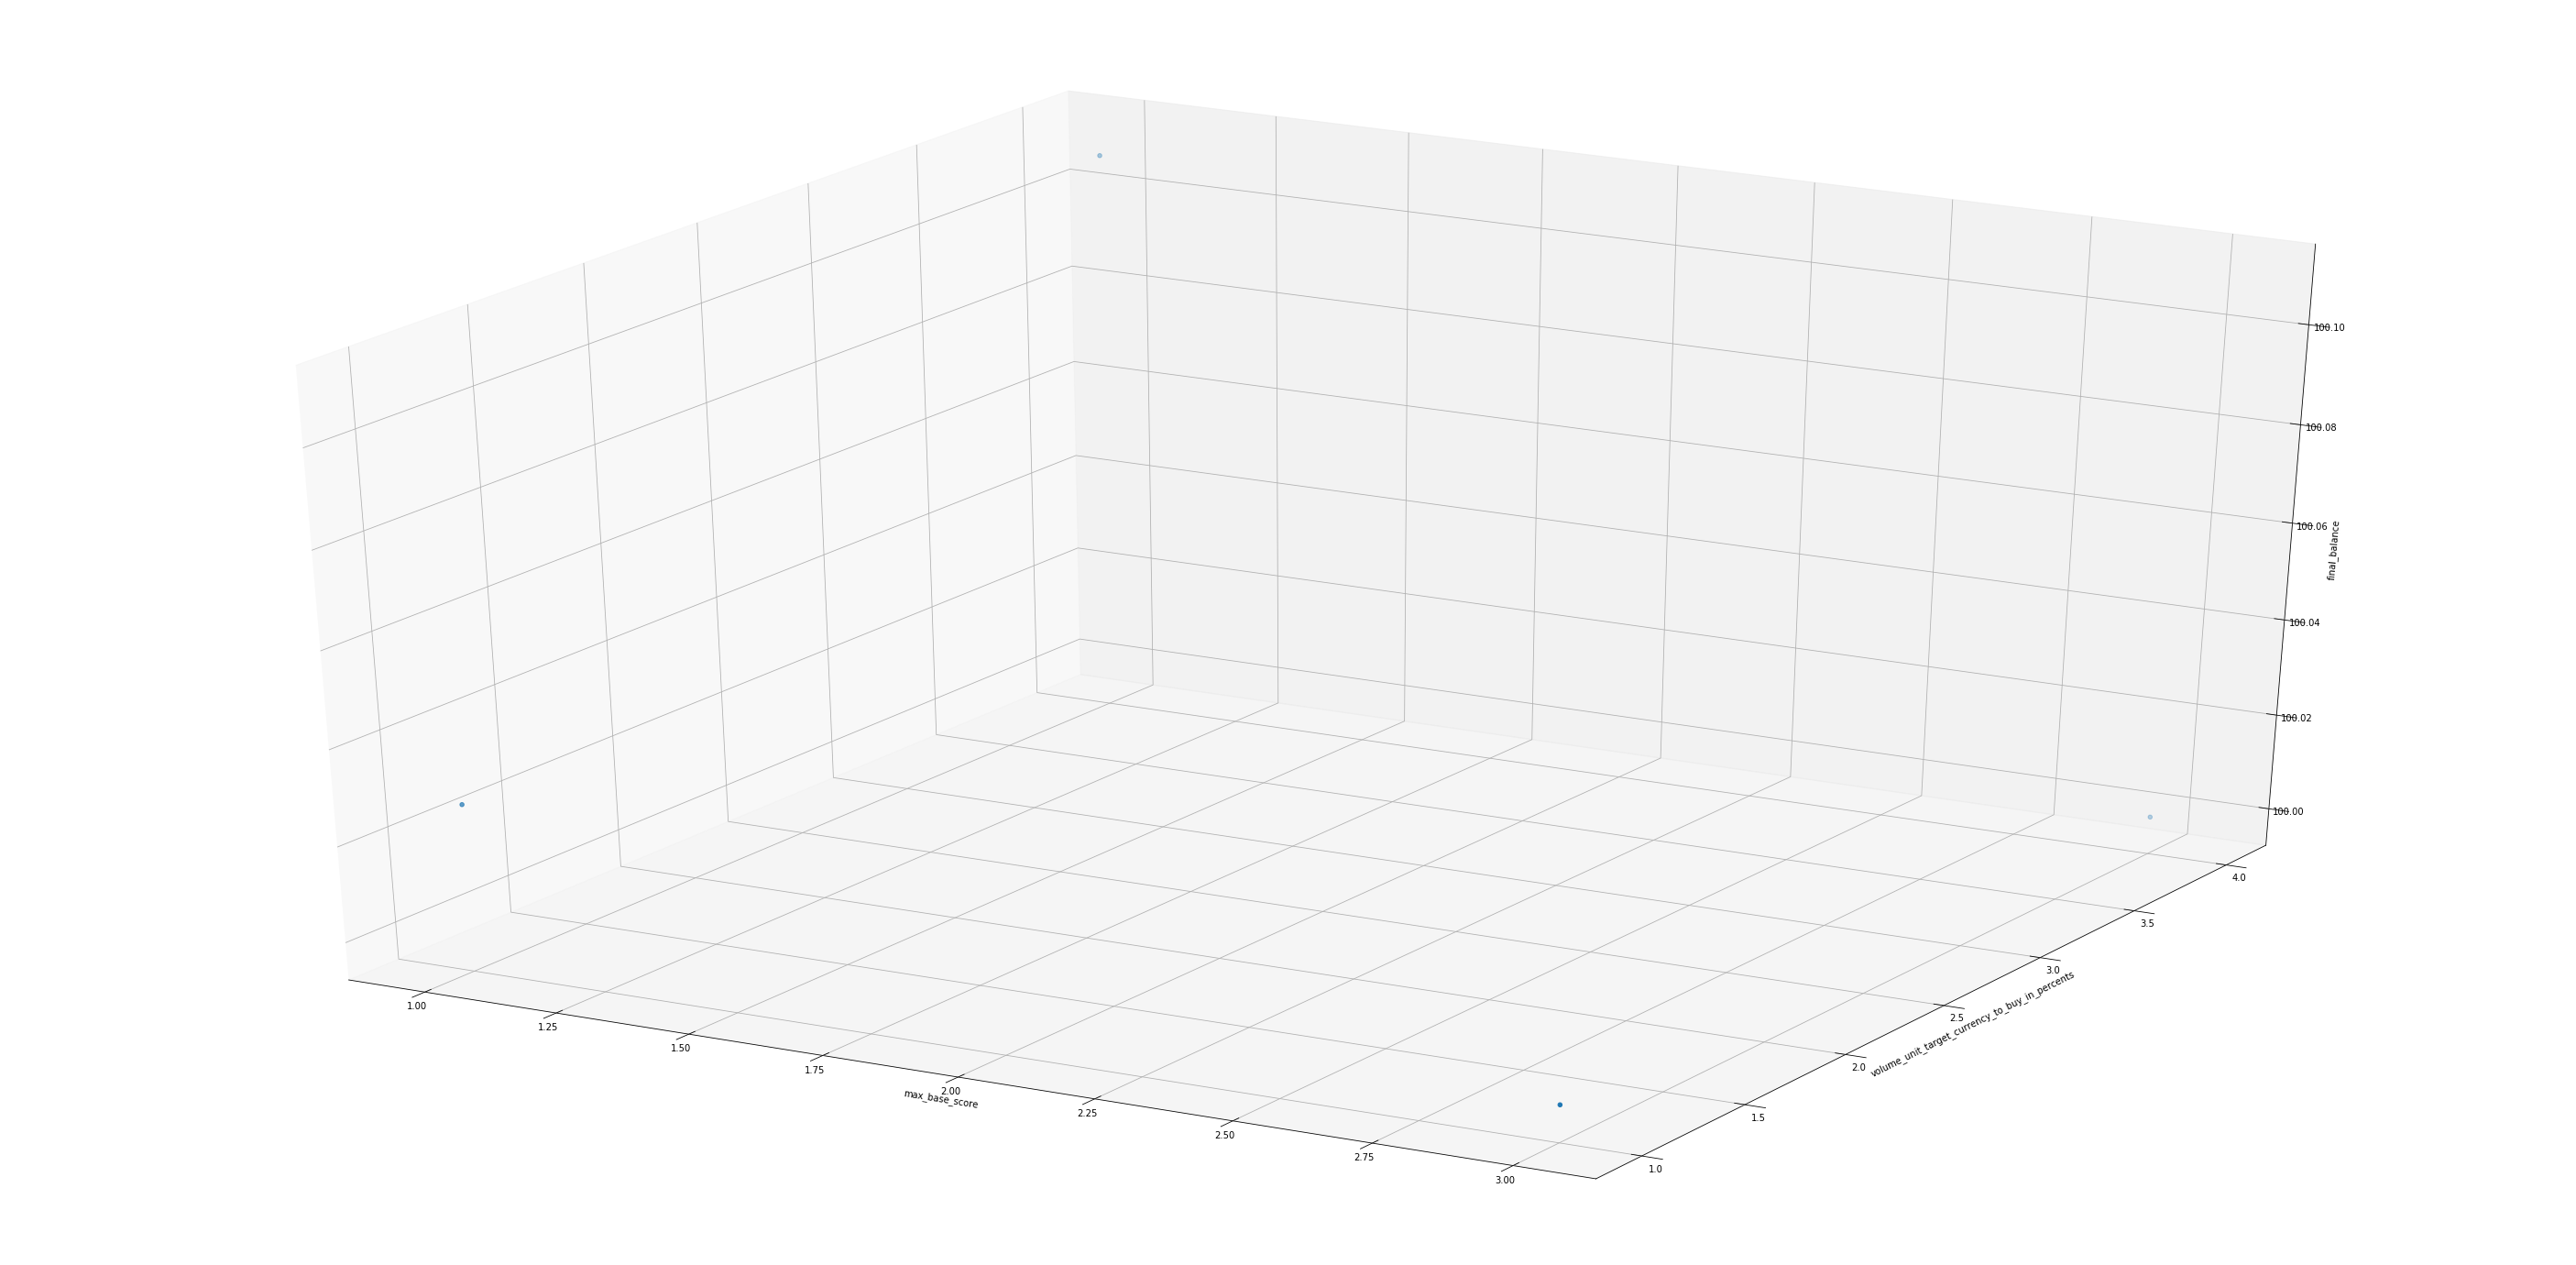

In [136]:
trading_fee_decimal = 0.0025

old_week_count = 1
new_week_count = 1

currency_pair = CurrencyPair('USDT', 'BTC', 0.0005)
# currency_pair = CurrencyPair('USDT', 'ETH', 0.0005)
# currency_pair = CurrencyPair('USDT', 'LTC', 0.0005)
# currency_pair = CurrencyPair('USDT', 'XMR', 0.0005)
# currency_pair = CurrencyPair('BTC', 'ETH', 0.0005)
# currency_pair = CurrencyPair('BTC', 'LTC', 0.0005)
# currency_pair = CurrencyPair('BTC', 'XMR', 0.0005)

# max_base_score = 2 if base_currency_symbol == 'USDT' and target_currency_symbol == 'BTC' else 1
# if base_currency_symbol == 'USDT' and target_currency_symbol == 'ETH':
#     volume_unit_target_currency_to_buy_in_percents = 1.6
# elif base_currency_symbol == 'USDT' and target_currency_symbol == 'BTC':
#     volume_unit_target_currency_to_buy_in_percents = 3.5
# else:
#     volume_unit_target_currency_to_buy_in_percents = 1.3

old_periods_json, new_periods_json, total_period_count, old_period_count = fetch_periods_prices_jsons(
    currency_pair, old_week_count, new_week_count)

max_base_score_array = []
volume_unit_target_currency_to_buy_in_percents_array = []
final_balance_array = []

for max_base_score_param in np.linspace(1, 3, num=2):  #num=5
    for volume_unit_target_currency_to_buy_in_percents_param in np.linspace(1, 4, num=2):  #num=30
        
        max_old_price_bin_count = 200
        old_periods, price_bin_offset = init_old_periods(old_periods_json, max_old_price_bin_count)
    
        median_volume_tmp = old_periods[PeriodColumns.VOLUME.value].median()
        mean_volume_tmp = old_periods[PeriodColumns.VOLUME.value].mean()
        multiplication_threshold_param = 2 * mean_volume_tmp / median_volume_tmp
        min_volume_per_period_threshold_param = mean_volume_tmp
        algorithm_config = AlgorithmConfig(max_base_score_param, volume_unit_target_currency_to_buy_in_percents_param,
                                           multiplication_threshold_param, min_volume_per_period_threshold_param,
                                           max_old_price_bin_count)
        print(algorithm_config)
        
        new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume = evaluate_algorithm(
            old_periods, price_bin_offset, new_periods_json, old_period_count, currency_pair, algorithm_config)
        
        # print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
        #                                 exchange_platform, price_bins, moving_overall_bin_max_volume)
        print_wallet(exchange_platform, new_periods)

        max_base_score_array.append(max_base_score_param)
        volume_unit_target_currency_to_buy_in_percents_array.append(volume_unit_target_currency_to_buy_in_percents_param)
        current_price_tmp = get_current_price(new_periods)
        final_balance_array.append(exchange_platform.wallet.get_total_in_base_currency(current_price_tmp))

draw_final_balance_graph(max_base_score_array, volume_unit_target_currency_to_buy_in_percents_array,
                         final_balance_array)